# Simulate a diffusion problem in 2D.

In the past, I had solve the heat equation in 1 dimension, using the explicit and implicit schemes for the numerical solution. So now, what about go one step beyond that and now study how work the 2D heat equation?

But hey, like I solved the heat equation before, why not now solve the Reaction-Diffusion equation? It's esentially the same for let's see that equation.

\begin{eqnarray}
\rho c_p\frac{\partial T}{\partial t}=\frac{\partial }{\partial x}\left(k_x\frac{\partial T}{\partial x}\right)+\frac{\partial }{\partial y}\left(k_y\frac{\partial T}{\partial y}\right)
\end{eqnarray}

where $\rho$ is the density, $c_p$ is the heat capacity and $k$ is the thermal conductivy. 

If we consider $k$ as a constant, we can take it outside of the spatial derivatives and dome some algebra to simplify the equation:

\begin{eqnarray}
\frac{\partial T}{\partial t}=\alpha\left(\frac{\partial^2 T}{\partial x^2}+\frac{\partial^2 T}{\partial y^2}\right)
\end{eqnarray}

where $\alpha=\frac{k}{\rho c_p}$ and it's called the thermal diffusivity constant. This constant describes the hability of a material to conduct heat vs storing it.

Does that equation have a familiar look to it? That's because it's the same as the diffusion equation. There's a reason that $\alpha$ is called the thermal diffusivity! We're going to set up an interesting problem where 2D heat conduction is important, and set about to solve it with explicit finite-difference methods.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits import mplot3d

## Problem statement

Removing heayt out of micro-chips is a big problem in the computer industry. We are at a point in technology where computers can't run much faster because the chips might start failing due to the high temperature. This is a big deal! Let's study the problem more closely.

We want to understand how heat is dissipated from the chip with a very simplified model. Say we consider the chip as a 2D plate of size $1$cm$\times$1cm, made of Silicon $k=159$W/mC, $c_p=0.712\cdot 10^3$J/kgC, $\rho=2329$kg/m^3, and diffusivity $\alpha\approx 10^{-4}$ m$^2$/s. Silicon melts at $1414$C, but chips should of course operate at much smaller temperaturs. The maximum temperature allowed depends on the processor make and model; in many cases, the maximum temperature is somewhere between 60C and $\approx$ 70C, but better CPUs are recommended to operate at a maximum of 80C.

We're going to set up a somewhat artificial problem, just to demonstrate an interesting numerical solution. Say the chip is in a position where on two edges (top and right) it is in contact with insulating material. On the other two edges the chip is touching other components that have a constant temperature of $T=$100C when the machine is operating. Initially, the chip is at room temperature (20C). How long does it take for the center of the chip to reach 70C?

<img src="Figure1_2D.png">

In [2]:
#------------------#
# Variables        #
#------------------#
rho=2329
alpha=1e-4
k=159
cp=0.712*(1e3)


#-------------------#
# x and y variables #
#-------------------#
#For x
xf=0.01 #Meters
Nx=150
dx=xf/Nx
x=np.linspace(0,xf,Nx)

#For y
yf=0.01 #Meters
Ny=150
dy=yf/Ny
y=np.linspace(0,yf,Ny)

#-------------------#
# t variable        #
#-------------------#
tf=0.25
dt=(dx**2)/alpha*0.25
Nt=tf/dt
t=np.linspace(0,tf,Nt)

In [3]:
def IC(Nx,Ny,Nt):
    #-----------------------------#
    # Put the initial values      #
    # for our matrix T at x=0 and #
    # y=0.                        #
    #-----------------------------#
    T=np.zeros((Nx,Ny,Nt))
    T[:,:,0]=20
    T[:,0,:]=100
    T[0,:,:]=100
    return T

T=IC(Nx,Ny,Nt)

## Explicit Scheme.

To solve the our equation, I can use Finite Differenses as a numerical method. First it's good to start with the explicit scheme.

Our derivative discretization for the derivative's (for $t,x$ and $y$) are:

\begin{equation}
\large\begin{array}{ccc}
\frac{\partial T}{\partial t}\approx\frac{T_{i,j}^{k+1}-T_{i,j}^{k}}{\Delta t} & \frac{\partial^2 T}{\partial x^2}\approx\frac{T_{i+1,j}^{k}-2T_{i,j}^{k}+T_{i-1,j}^{k}}{\Delta x^2} & \frac{\partial^2 T}{\partial y^2}\approx\frac{T_{i,j+1}^{k}-2T_{i,j}^{k}+T_{i,j-1}^{k}}{\Delta y^2}
\end{array}\end{equation}

So, i can rewrite the PDE as:

\begin{equation}
\frac{T_{i,j}^{k+1}-T_{i,j}^{k}}{\Delta t}=\alpha\left(\frac{T_{i+1,j}^{k}-2T_{i,j}^{k}+T_{i-1,j}^{k}}{\Delta x^2}+\frac{T_{i,j+1}^{k}-2T_{i,j}^{k}+T_{i,j-1}^{k}}{\Delta y^2}\right)
\end{equation}

Rearranging the equation to solve it for $k+1$ time, yields

\begin{equation}
T_{i,j}^{k+1}=T_{i,j}^{k}+\alpha\left(\frac{\Delta t}{\Delta x^2}\left(T_{i+1,j}^{k}-2T_{i,j}^{k}+T_{i-1,j}^{k}\right)+\frac{\Delta t}{\Delta y^2}\left(T_{i,j+1}^{k}-2T_{i,j}^{k}+T_{i,j-1}^{k}\right)\right)
\end{equation}

In [4]:
def solution(Nx,Ny,Nt,alpha,dt,dy,dx):
    #--------------------------------#
    # Put all together and solve the #
    # system using Finite Difference #
    #--------------------------------#
    T=IC(Nx,Ny,Nt) #Call the Initial Conditions
    T=BC(T,0)      #Boundary conditions
    for k in range(Nt-1):
        dTdx=T[2:,1:-1,k]-2*T[1:-1,1:-1,k]+T[:-2,1:-1,k]
        dTdy=T[1:-1,2:,k]-2*T[1:-1,1:-1,k]+T[1:-1,:-2,k]
        #Now, calculate the next time step
        T[1:-1,1:-1,k+1]=T[1:-1,1:-1,k]+alpha*(dt/dx**2)*dTdx+alpha*(dt/dy**2)*dTdy
        T=BC(T,k+1)
    return T

## Boundary Conditions.

Whenever we reach a point that interacts with the boundary, we apply the boundary condition. As in the previous notebook, if the boundary has Dirichlet conditions, we simply impose the prescribed temperature at that point. If the boundary has Neumann conditions, we approximate them with a finite-difference scheme.

Remember, Neumman boundary conditions prescribe the derivative in the normal direction. For example, in the problem described above, we have $\partial T/\partial y=q_y$ in the top boundary and $\partial T/\partial x=q_x$ in the right boundary, with $q_y=q_x=0$ (insulation).

Thus, at every time step, we need to enforce:

\begin{eqnarray}
T_{i,\text{end}+1}^{k}=q_y\cdot\Delta y+T_{i,\text{end}-1}^{k} \\
T_{\text{end}+1,j}^{k}=q_x\cdot\Delta x+T_{\text{end}-1,j}^{k}
\end{eqnarray}

Since $q_y=q_x=0$, i had:

\begin{eqnarray}
T_{i,\text{end}+1}^{k}=T_{i,\text{end}-1}^{k} \\
T_{\text{end}+1,j}^{k}=T_{\text{end}-1,j}^{k}
\end{eqnarray}

In [5]:
def BC(T,j):
    T[-1,:,j]=T[-3,:,j]
    T[:,-1,j]=T[:,-3,j]
    return T

## Stability.

Before doing the code, let's revisit Stability constraints. We saw a long time that the 1D explicit discretization of the heat/diffusion equation was stable as long as $\alpha\frac{\Delta}{\Delta x^2}\leq \frac{1}{2}$. In 2D, this constraint is even tighter, as we need to add them in both directions:

\begin{equation}
\alpha\frac{\Delta t}{\Delta x^2}+\alpha\frac{\Delta t}{\Delta y^2}<\frac{1}{2}
\end{equation}

Say that the mesh has the same spacing in $x$ and $y$, $\Delta x=\Delta y=\delta$. In that case, the Stability conditions is:

\begin{equation}
\alpha\frac{\Delta t}{\delta^2}<\frac{1}{4}
\end{equation}

In [6]:
def stability(alpha,dt,delta):
    return alpha*(dt/delta**2)

CFL=stability(alpha,dt,dx)
print('The value given by the stability function is:',CFL)

The value given by the stability function is: 2.2499999999999996


In [7]:
%time T=solution(Nx,Ny,Nt,alpha,dt,dy,dx)

ipykernel_launcher:5: RuntimeWarning: overflow encountered in add
ipykernel_launcher:6: RuntimeWarning: overflow encountered in add
ipykernel_launcher:8: RuntimeWarning: overflow encountered in multiply
ipykernel_launcher:8: RuntimeWarning: overflow encountered in add
ipykernel_launcher:5: RuntimeWarning: overflow encountered in multiply
ipykernel_launcher:5: RuntimeWarning: overflow encountered in subtract
ipykernel_launcher:6: RuntimeWarning: overflow encountered in multiply
ipykernel_launcher:6: RuntimeWarning: overflow encountered in subtract
ipykernel_launcher:8: RuntimeWarning: invalid value encountered in add
ipykernel_launcher:5: RuntimeWarning: invalid value encountered in add
ipykernel_launcher:6: RuntimeWarning: invalid value encountered in add
ipykernel_launcher:5: RuntimeWarning: invalid value encountered in subtract
ipykernel_launcher:6: RuntimeWarning: invalid value encountered in subtract
CPU times: user 9.25 s, sys: 219 ms, total: 9.47 s
Wall time: 9.5 s


In [8]:
T_lim=T[int(Nx/2),int(Ny/2),0]
ind=0
while T_lim<70:
    ind+=1
    T_lim=T[int(Nx/2),int(Ny/2),ind]

ind #This is the indice of the time step where the condition is fullfilled.
print('The temperature at the center is T={f}C at a time t={d}s'.format(f=round(T_lim,2),d=round(t[ind],2)))

The temperature at the center is T=70.01C at a time t=0.16s


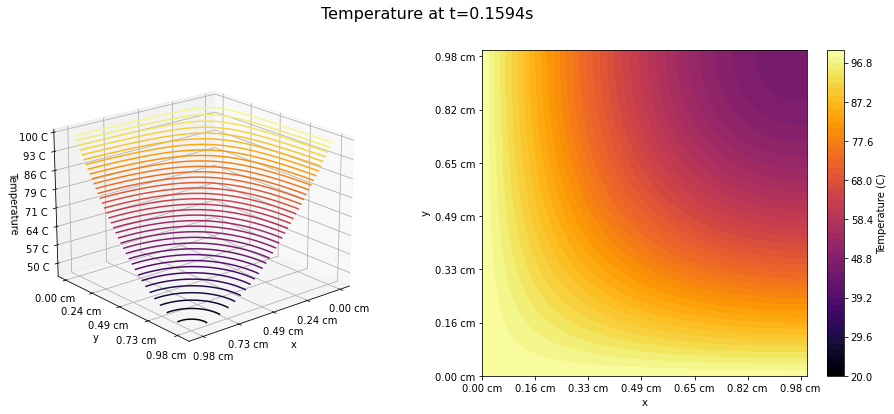

In [10]:
def plot(T,x,y,Nx,Ny,ind):
    fig=plt.figure(figsize=(16,6))

    ax1=fig.add_subplot(121,projection='3d')
    ax1.contour3D(x,y,T[:,:,ind],50,cmap='inferno')
    ax1.set_xlabel('x')
    ax1.set_xticks([x[i] for i in range(0,Nx,int(Nx/5+2))])
    ax1.set_xticklabels(['{0:.2f} cm'.format(x[i]*100) for i in range(0,Nx,int(Nx/5+2))])
    ax1.set_ylabel('y')
    ax1.set_yticks([y[i] for i in range(0,Ny,int(Ny/5+2))])
    ax1.set_yticklabels(['{0:.2f} cm'.format(y[i]*100) for i in range(0,Ny,int(Ny/5+2))])
    ax1.set_zlabel('Temperature')

    Tem=np.linspace(0,100,15)

    ax1.set_zticks(Tem)
    ax1.set_zticklabels(['{0:.0f} C'.format(Tem[i]) for i in range(0,len(Tem))])
    ax1.view_init(20,50)


    #----------------------------------------------------------------------------------#
    # Second plot, the contour in 2D

    ax2=fig.add_subplot(122)
    ax2.set_xlim(0,xf)
    ax2.set_ylim(0,yf)
    ax2.set_xlabel('x')
    ax2.set_xticks([x[i] for i in range(0,Nx,int(Nx/6))])
    ax2.set_xticklabels(['{0:.2f} cm'.format(x[i]*100) for i in range(0,Nx,int(Nx/6))])
    ax2.set_ylabel('y')
    ax2.set_yticks([y[i] for i in range(0,Ny,int(Ny/6))])
    ax2.set_yticklabels(['{0:.2f} cm'.format(y[i]*100) for i in range(0,Ny,int(Ny/6))])
    levels=np.linspace(20,100,num=51)
    cont=ax2.contourf(x,y,T[:,:,ind], levels=levels, cmap='inferno')
    cbar=plt.colorbar(cont)
    cbar.set_label('Temperature (C)')
    #----------------------------------------------------------------------------------#

    fig.suptitle('Temperature at t={0:.4f}s'.format(t[ind]), fontsize=16)

plot(T,x,y,Nx,Ny,ind)

In [87]:
fig=plt.figure(figsize=(16,6))

ax1=fig.add_subplot(121,projection='3d')
ax1.contour3D(x,y,T[:,:,0],50,cmap='inferno')
ax1.set_xlabel('x')
ax1.set_xticks([x[i] for i in range(0,Nx,int(Nx/5+2))])
ax1.set_xticklabels(['{0:.2f} cm'.format(x[i]*100) for i in range(0,Nx,int(Nx/5+2))])
ax1.set_ylabel('y')
ax1.set_yticks([y[i] for i in range(0,Ny,int(Ny/5+2))])
ax1.set_yticklabels(['{0:.2f} cm'.format(y[i]*100) for i in range(0,Ny,int(Ny/5+2))])
ax1.set_zlabel('Temperature')

Tem=np.linspace(0,100,6)

ax1.set_zticks(Tem)
ax1.set_zticklabels(['{0:.0f} C'.format(Tem[i]) for i in range(0,len(Tem))])
ax1.view_init(20,20)



#----------------------------------------------------------------------------------#
# Second plot, the contour in 2D

ax2=fig.add_subplot(122)
ax2.set_xlim(0,xf)
ax2.set_ylim(0,yf)
ax2.set_xlabel('x')
ax2.set_xticks([x[i] for i in range(0,Nx,int(Nx/6))])
ax2.set_xticklabels(['{0:.2f} cm'.format(x[i]*100) for i in range(0,Nx,int(Nx/6))])
ax2.set_ylabel('y')
ax2.set_yticks([y[i] for i in range(0,Ny,int(Ny/6))])
ax2.set_yticklabels(['{0:.2f} cm'.format(y[i]*100) for i in range(0,Ny,int(Ny/6))])
levels=np.linspace(20,100,num=51)
cont=ax2.contourf(x,y,T[:,:,0], levels=levels, cmap='inferno')
cbar=plt.colorbar(cont)
cbar.set_label('Temperature (C)')
#----------------------------------------------------------------------------------#

frames=np.linspace(0,Nt-1,600)
frames=frames.astype(int)


def animate(i):
    global x,y,t,T,plots,levels, Tem
    ax1.clear()
    ax2.clear()
    #----------------------------------------------------------------#
    ax1.set_xlabel('x')
    ax1.set_xticks([x[i] for i in range(0,Nx,int(Nx/5+2))])
    ax1.set_xticklabels(['{0:.2f} cm'.format(x[i]*100) for i in range(0,Nx,int(Nx/5+2))])
    ax1.set_ylabel('y')
    ax1.set_yticks([y[i] for i in range(0,Ny,int(Ny/5+2))])
    ax1.set_yticklabels(['{0:.2f} cm'.format(y[i]*100) for i in range(0,Ny,int(Ny/5+2))])
    #ax1.set_zlabel('Temperature')

    ax1.set_zlim(0,100)
    ax1.set_zticks(Tem)
    ax1.set_zticklabels(['{0:.0f} C'.format(Tem[i]) for i in range(0,len(Tem))])
    ax1.contour3D(x,y,T[:,:,i],51,cmap='inferno')

    #----------------------------------------------------------------#
    #Second plot
    ax2.set_xlim(0,xf)
    ax2.set_ylim(0,yf)
    ax2.set_xlabel('x')
    ax2.set_xticks([x[i] for i in range(0,Nx,int(Nx/6))])
    ax2.set_xticklabels(['{0:.2f} cm'.format(x[i]*100) for i in range(0,Nx,int(Nx/6))])
    ax2.set_ylabel('y')
    ax2.set_yticks([y[i] for i in range(0,Ny,int(Ny/6))])
    ax2.set_yticklabels(['{0:.2f} cm'.format(y[i]*100) for i in range(0,Ny,int(Ny/6))])
    ax2.contourf(x,y,T[:,:,i], levels=levels, cmap='inferno')

    fig.suptitle('Temperature at t={0:.4f}s'.format(t[i]), fontsize=16)

anim=FuncAnimation(fig,animate,frames=frames,interval=30,blit=False)
plt.close()
%time anim.save('temperature_2d.mp4',fps=60)

CPU times: user 6min 13s, sys: 6.67 s, total: 6min 20s
Wall time: 6min 24s
